In [1]:
# Import the libaries

import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [2]:
# Device Agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Get Data

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
  print(f"Creating {image_path} directory")
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip the file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)



Creating data/pizza_steak_sushi directory
Unzipping pizza, steak, sushi data...


In [4]:
# Data Exploration and Preparation

import os

def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [5]:
# Setting Train and Testing Paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/sushi/794647.jpg
Image class: sushi
Image height: 512
Image width: 512


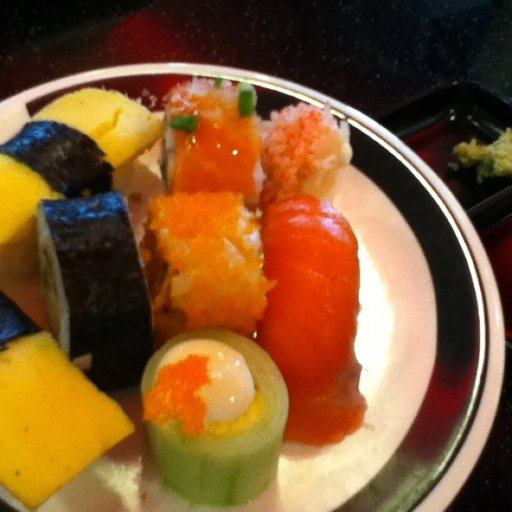

In [6]:
# Visualizing an Image

import random
from PIL import Image

#random.seed(42)
image_path_list = list(train_dir.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img



Text(0.5, 1.0, 'Image class: sushi | Image shape: (512, 512, 3) | Image dtype: uint8')

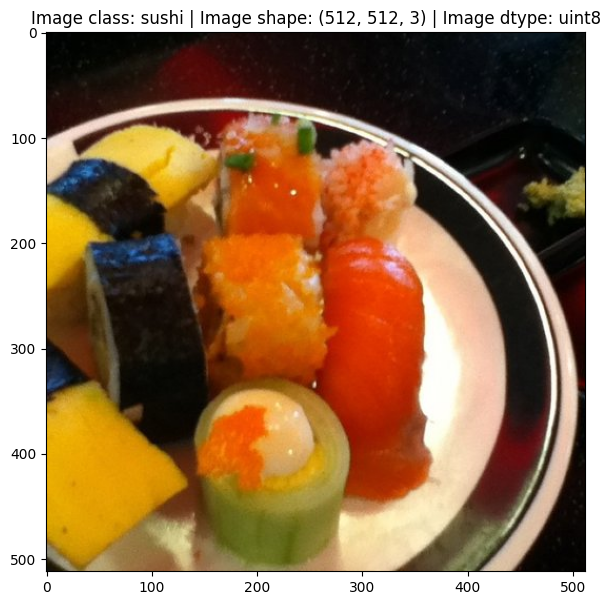

In [7]:
# Visualize the image with Matploitlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} | Image dtype: {img_as_array.dtype}")

array([[[ 1,  3,  2],
        [ 2,  4,  3],
        [ 2,  4,  3],
        ...,
        [17, 21, 22],
        [18, 22, 23],
        [19, 23, 24]],

       [[ 1,  3,  2],
        [ 2,  4,  3],
        [ 2,  4,  3],
        ...,
        [13, 17, 18],
        [14, 18, 19],
        [15, 19, 20]],

       [[ 1,  3,  2],
        [ 2,  4,  3],
        [ 2,  4,  3],
        ...,
        [12, 16, 17],
        [13, 17, 18],
        [14, 18, 19]],

       ...,

       [[18, 19, 11],
        [17, 18, 10],
        [18, 18, 10],
        ...,
        [ 4,  3,  1],
        [ 5,  4,  2],
        [ 5,  4,  2]],

       [[18, 20, 17],
        [18, 19, 14],
        [20, 19, 15],
        ...,
        [ 3,  2,  0],
        [ 4,  3,  1],
        [ 4,  3,  1]],

       [[15, 17, 16],
        [15, 17, 16],
        [18, 17, 15],
        ...,
        [ 3,  2,  0],
        [ 3,  2,  0],
        [ 4,  3,  1]]], dtype=uint8)
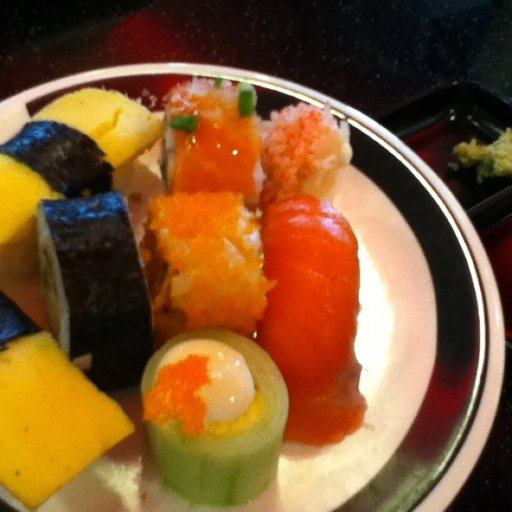

In [8]:
img_as_array

In [9]:
# Tranforming Data

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


In [10]:
# Write a transform for Image

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

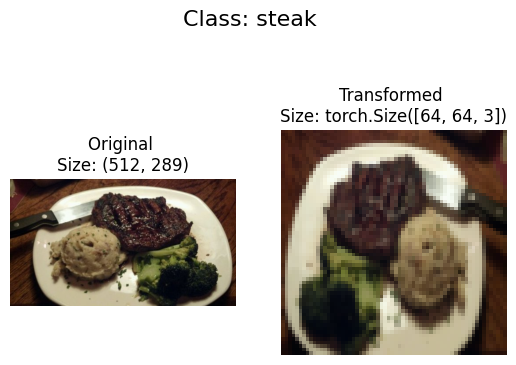

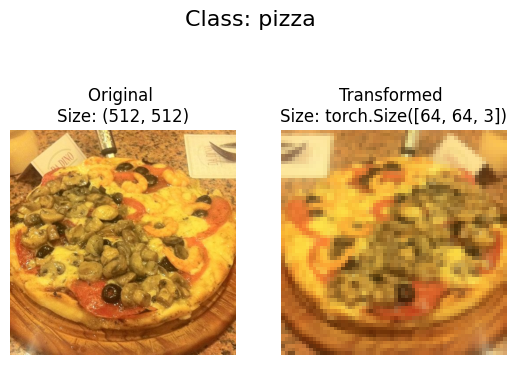

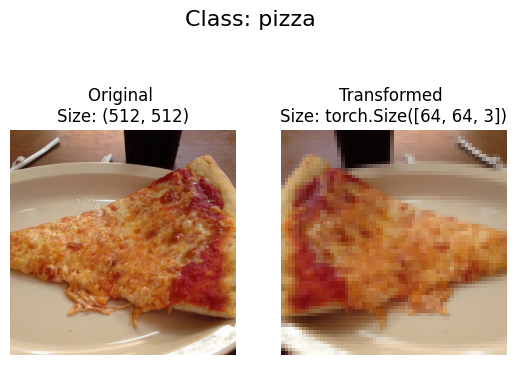

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [13]:
# Loading Image Data using ImageFolder

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Class: {class_name[label]}")
print(f"Image Tensor:\n {img}")


Image shape: torch.Size([3, 64, 64])
Label: 0
Class: pizza
Image Tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0

Text(0.5, 1.0, 'Class: pizza')

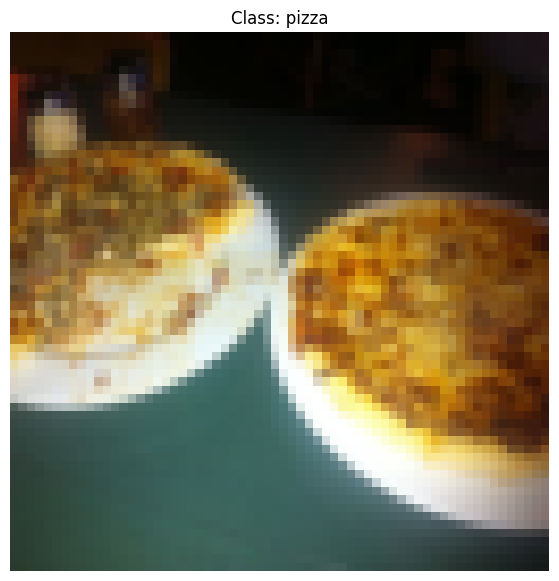

In [18]:
img_permute = img.permute(1, 2, 0)

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(f"Image shape: {img_permute.shape}")
plt.axis("off")
plt.title(f"Class: {class_name[label]}")

In [19]:
import os
os.cpu_count()

2

In [20]:
# Turn into DataLoader

from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7dbcf6627210>,
 <torch.utils.data.dataloader.DataLoader at 0x7dbcf667d6d0>)

In [21]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


In [22]:
# Loading Image Data with a custom Dataset

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [23]:
# Create a helper function to get class names

target_directory = train_dir
class_names_found = sorted([entry.name for entry in os.scandir(target_directory) if entry.is_dir()])
class_names_found

['pizza', 'steak', 'sushi']

In [24]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Find the class folder name in a target directory """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    return classes, class_to_idx

In [25]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [26]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


In [27]:
# Create a Transform
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [28]:
# Testing the IMageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                       transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7dbcf6636410>,
 <__main__.ImageFolderCustom at 0x7dbcfe90ab50>)

In [29]:
train_data_custom[0][0].shape

torch.Size([3, 64, 64])

In [30]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [31]:
# Check for equality between both

print(train_data_custom.classes==train_data.classes)
print(train_data_custom.class_to_idx==train_data.class_to_idx)

True
True


In [32]:
# Create a Helper function to display random image

def display_random_image(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int =10,
                         display_shape:bool = True,
                         seed: int = None):
  if n >10:
    n = 10
    display_shape = False
    print(f" For dsiplay purpose n shouldn't be greater than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image.permute(1, 2, 0))
    if classes:
      plt.title(f"class: {classes[targ_label]}")


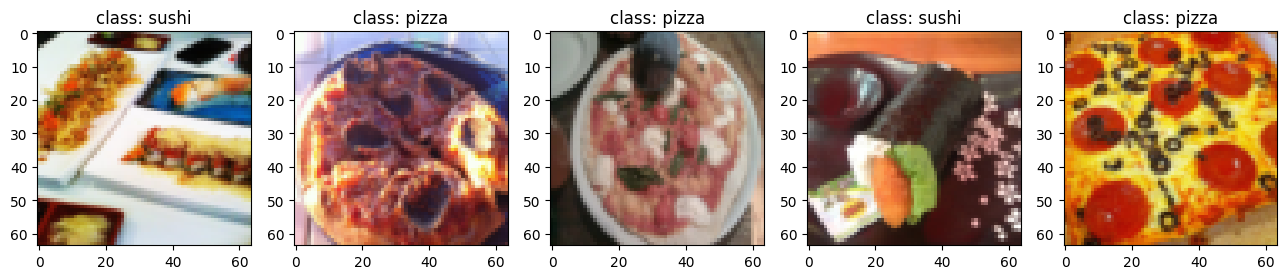

In [33]:
# Display Images

display_random_image(train_data,
                     n=5,
                     classes=class_name,
                     seed=42)

In [34]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS = os.cpu_count()
#train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     #batch_size=BATCH_SIZE,
                                     #num_workers=NUM_WORKERS,
                                     #shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
#train_dataloader_custom, test_dataloader_custom


In [35]:
# Data Argumentation

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [36]:
image_path

PosixPath('data/pizza_steak_sushi')

In [37]:
# Model 0: TinyVGG without Data Argumentation

simple_tranform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [38]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform=simple_tranform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                  transform=simple_tranform)
train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [39]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size= BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)



In [40]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    print(x.shape)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    print(x.shape)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [41]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_name)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [42]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [43]:
model_0(image_batch)

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [44]:
# Use torchinfo

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=(32,3,64,64))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [45]:
# Creating the Train and Test Loops

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()
  train_loss, train_acc =0,0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [52]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()
  test_loss, test_acc =0,0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc

In [47]:
from tqdm.auto import tqdm

def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results



In [53]:
# Train and evaluate Model_0 on Custom Dataset
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([11, 10, 30, 30])
torch.Size([11, 10, 13, 13])
torch.Size([11, 3])
Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13]

In [54]:
# Loss Curve

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [55]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()


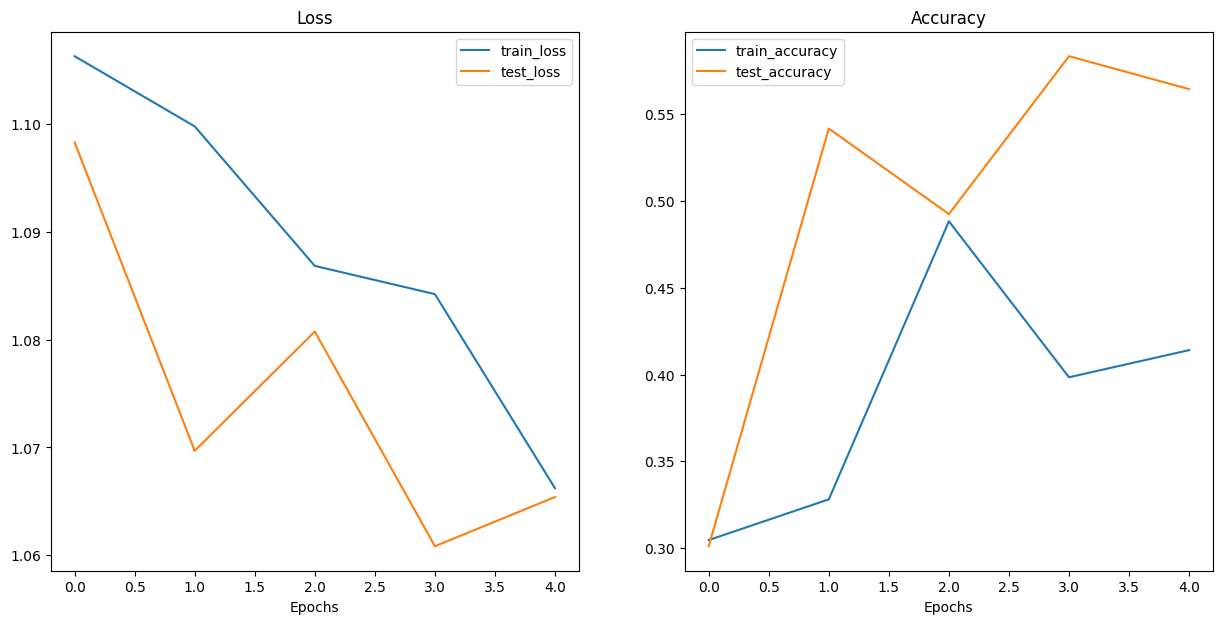

In [56]:
plot_loss_curves(model_0_results)

In [58]:
# Model_1: TinyVGG with Data Argumentation

from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])



In [60]:
# Create train and test dataset and dataloader with data argumentation

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                      transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                     transform=test_transform_simple)


In [62]:
# Turn Dataset to DataLoaders

import os
from torch.utils.data import DataLoader

BATCH_SIZE =32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


In [63]:
# Contruct and Train Model_1

torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [64]:
torch.manual_seed(42)

NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([11, 10, 30, 30])
torch.Size([11, 10, 13, 13])
torch.Size([11, 3])
Epoch: 1 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13]

In [65]:
model_1_results

{'train_loss': [1.104914203286171,
  1.0806865319609642,
  1.0711720064282417,
  1.125308334827423,
  1.0865339040756226],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1019279559453328,
  1.1260557969411213,
  1.159274657567342,
  1.1580672065416973,
  1.1554409265518188],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3333333333333333]}

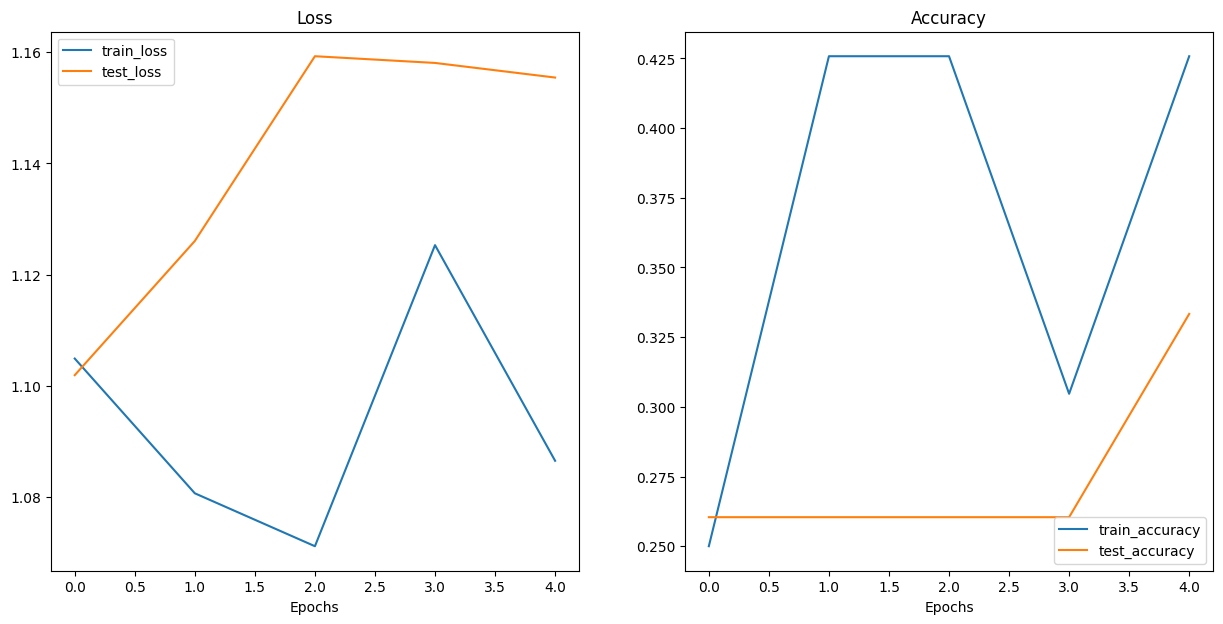

In [67]:
# Plot the Loss Curve of Model_1

plot_loss_curves(model_1_results)

In [68]:
# Comparing our Models Side-by-Side

import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df


,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


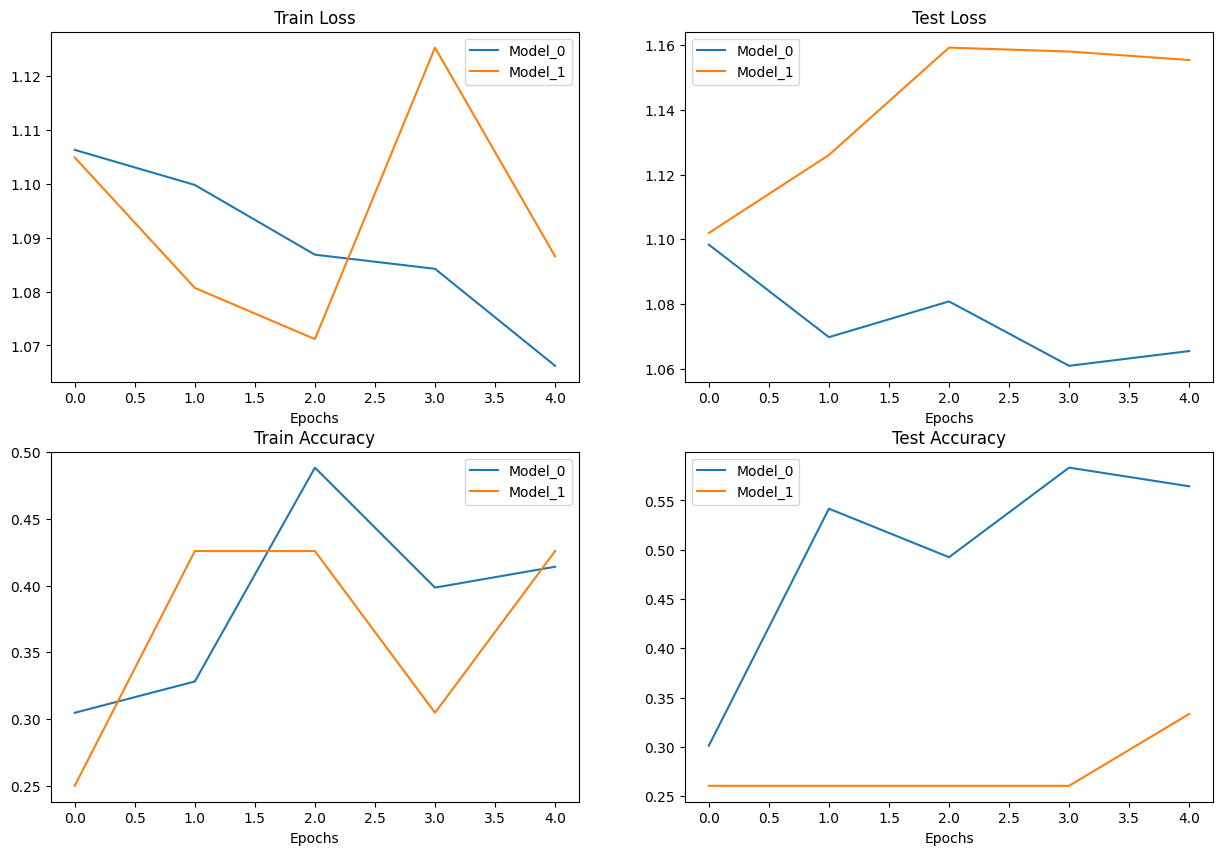

In [73]:
# Setup a PLot

plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.show()



In [77]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


In [79]:
# Load the Custom image with Pytorch

import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

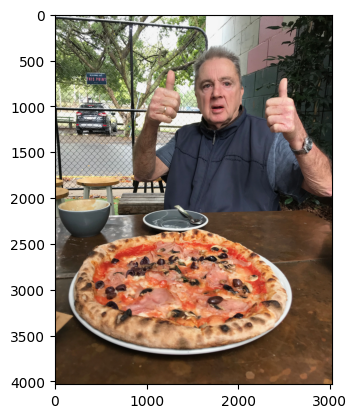

In [80]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [81]:
print(f"Shape: {custom_image_uint8.shape}")
print(f"Datatype: {custom_image_uint8.dtype}")
print(f"Min value: {custom_image_uint8.min()}")
print(f"Max value: {custom_image_uint8.max()}")

Shape: torch.Size([3, 4032, 3024])
Datatype: torch.uint8
Min value: 0
Max value: 255


In [85]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

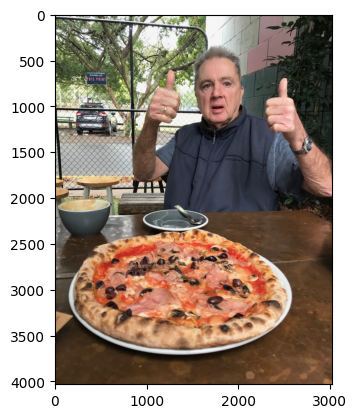

In [88]:
plt.imshow(custom_image.permute(1,2,0))

In [89]:
# Create Transform Pipeline to resize Image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original Shape: {custom_image.shape}")
print(f"Transformed Shape: {custom_image_transformed.shape}")


Original Shape: torch.Size([3, 4032, 3024])
Transformed Shape: torch.Size([3, 64, 64])


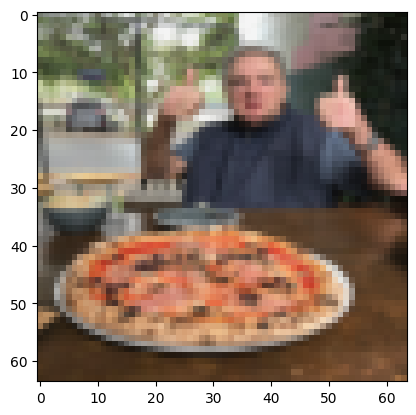

In [90]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [92]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
custom_image_pred

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


tensor([[ 0.0781,  0.0379, -0.2067]])

In [93]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [94]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0])

In [96]:
# Putting Custom Image Prediction Together

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image / 255.
  if transform:
    target_image = transform(target_image)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image_pred = model(target_image.unsqueeze(dim=0).to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)



In [100]:
class_names = train_data_augmented.classes
class_names

['pizza', 'steak', 'sushi']

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


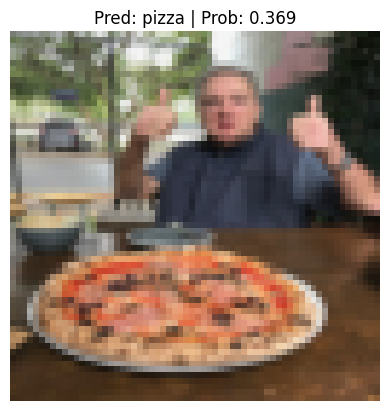

In [108]:
# Prediction on our Custom Image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)